In [1]:
import numpy as np
import numpy.linalg as la
import scipy.integrate as integrate
import matplotlib
import matplotlib.pyplot as plt

import zmtc

In [2]:
# Model settings
# Effective tau for new closure (seconds)
tau = 1800.
# Critical CAPE value (J/kg).
a_crit = 70.
# Initial CAPE (J/kg).
a0 = 0.

In [3]:
def constant_rate(dadtls):
    """Returns a function providing a constant rate of forcing."""
    return (lambda t: dadtls)

def sinusoidal_rate(mean_dadtls, dadt_osc_mag, dadt_osc_period, dadt_osc_phase=0.):
    """Returns a function providing a sinusoidally varying rate of forcing."""
    return (lambda t: mean_dadtls + dadt_osc_mag * np.sin(2.*np.pi*(t / dadt_osc_period) + dadt_osc_phase))

def total_tend_from_forcing(forcing, a_crit, tau):
    """Given a forcing rate function and convection-related constants, returns a function for CAPE tendency."""
    return (lambda t, y: forcing(t) - np.clip(y[0] - a_crit, 0., None) / tau)

def integrate_exact(total_tend, a0, t_eval):
    """Integrates CAPE over a given time span."""
    # Initial state array
    y0 = np.array([a0])
    # Time span
    t_span = (t_eval[0], t_eval[-1])
    sol = integrate.solve_ivp(total_tend, t_span, y0, t_eval=t_eval, rtol=1.e-6)
    return sol.y[0,:]

def old_closure(tau, a_crit):
    """Given convection-related constants, returns (dA/dt)_c using the old closure formula."""
    return (lambda _, a_star: - np.clip(a_star - a_crit, 0., None) / tau)

def zmtc_closure(tau, a_crit, deltat):
    """Given convection-related constants, returns (dA/dt)_c using the zmtc formula."""
    return (lambda a_prev, a_star: -zmtc.cape_consumption_rate(tau, a_crit, deltat, a_prev, a_star))

def integrate_seq_split_euler(forcing, closure, a0, deltat, t_eval):
    """Uses the Euler method to integrate CAPE given external forcing and a closure."""
    duration = t_eval[-1] - t_eval[0]
    n_steps = int(duration / deltat) + 1
    t_step = np.linspace(t_eval[0], t_eval[0] + n_steps*deltat, n_steps + 1)
    a_step = np.zeros((n_steps + 1,))
    a_step[0] = a0
    for i in range(n_steps):
        a_prev = a_step[i]
        # Approximate forcing through interpolation
        # a_star = a_prev + 0.5 * (forcing(t_step[i]) + forcing(t_step[i+1])) * deltat
        # Nearly "exact" forcing using quadrature
        a_star = a_prev + integrate.quad(forcing, t_step[i], t_step[i+1])[0]
        dadtc = closure(a_prev, a_star)
        a_step[i+1] = a_star + dadtc * deltat
    a_eval = np.interp(t_eval, t_step, a_step)
    return a_eval

def integrate_old_closure(forcing, tau, a_crit, a0, deltat, t_eval):
    """Integrates CAPE in response to given forcing using the old closure formula."""
    closure = old_closure(tau, a_crit)
    return integrate_seq_split_euler(forcing, closure, a0, deltat, t_plot)

def integrate_zmtc_closure(forcing, tau, a_crit, a0, deltat, t_eval):
    """Integrates CAPE in response to given forcing using the zmtc closure formula."""
    closure = zmtc_closure(tau, a_crit, deltat)
    return integrate_seq_split_euler(forcing, closure, a0, deltat, t_plot)

def plot_different_methods(forcing, tau, a_crit, a0, deltat, t_plot):
    """Plot CAPE over time using the exact method, old, and zmtc closures.

    Both the old closure with the same tau is plotted, and the old closure with
    an adjusted tau to achieve the same equilibrium CAPE.
    """
    # Exact solution
    total_tend = total_tend_from_forcing(forcing, a_crit, tau)
    a_plot_exact = integrate_exact(total_tend, a0, t_plot)

    # Adjust tau so that old method gives the same equilibrium condition.
    tau_adj = tau + deltat
    a_plot_euler_old = integrate_old_closure(forcing, tau, a_crit, a0, deltat, t_plot)
    a_plot_euler_old_adj = integrate_old_closure(forcing, tau_adj, a_crit, a0, deltat, t_plot)
    a_plot_euler_zmtc = integrate_zmtc_closure(forcing, tau, a_crit, a0, deltat, t_plot)

    # Plot output
    plt.plot(t_plot / 3600., a_plot_exact, color='k')
    plt.plot(t_plot / 3600., a_plot_euler_old, color='r')
    plt.plot(t_plot / 3600., a_plot_euler_old_adj, color='b')
    plt.plot(t_plot / 3600., a_plot_euler_zmtc, color='g')
    plt.xlabel('t (hr)')
    plt.ylabel('CAPE')

In [4]:
def predefined_settings(index):
    """Selects a predetermined forcing function and run length from a list."""
    # Run start time (seconds)
    t_initial = 0.
    if index == 0:
        # Constant forcing case
        forcing = constant_rate(0.04)
        # Run end time (seconds)
        t_final = 3600. * 4.
    elif index == 1:
        # Sinusoidal forcing case with daily period
        forcing = sinusoidal_rate(0.04, 0.045, 86400.)
        # Run end time (seconds)
        t_final = 3600. * 24.
    elif index == 2:
        # Sinusoidal forcing case with daily period
        forcing = sinusoidal_rate(0.04, 0.08, 3600. * 3.)
        # Run end time (seconds)
        t_final = 3600. * 4.
    elif index == 3:
        # Sinusoidal forcing case with daily period
        forcing = sinusoidal_rate(0.04, 0.2, 3600.)
        # Run end time (seconds)
        t_final = 3600. * 3.
    else:
        # Just give up
        assert False, "index is not valid"
    # Number of points plotted over this time span
    num_ts_plot = 1001
    # Array of points in time to plot (seconds)
    t_plot = np.linspace(t_initial, t_final, num_ts_plot + 1)
    return (forcing, t_plot)

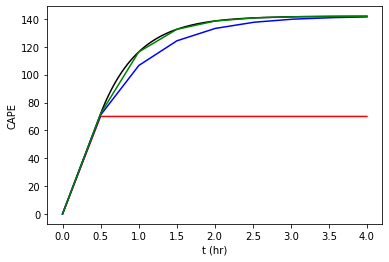

In [5]:
# Integration timestep (seconds)
deltat = 1800.
# Predefined case
forcing, t_plot = predefined_settings(0)

plot_different_methods(forcing, tau, a_crit, a0, deltat, t_plot)

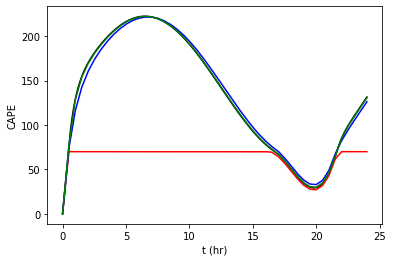

In [6]:
# Integration timestep (seconds)
deltat = 1800.
# Predefined case
forcing, t_plot = predefined_settings(1)

plot_different_methods(forcing, tau, a_crit, a0, deltat, t_plot)

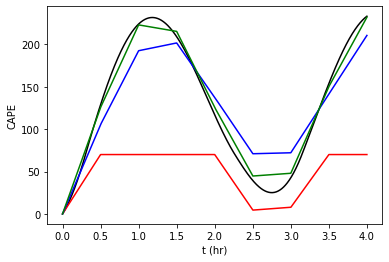

In [7]:
# Integration timestep (seconds)
deltat = 1800.
# Predefined case
forcing, t_plot = predefined_settings(2)

plot_different_methods(forcing, tau, a_crit, a0, deltat, t_plot)

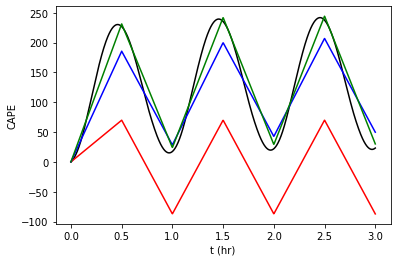

In [8]:
# Integration timestep (seconds)
deltat = 1800.
# Predefined case
forcing, t_plot = predefined_settings(3)

plot_different_methods(forcing, tau, a_crit, a0, deltat, t_plot)

In [9]:
def plot_old_without_tau_adj(forcing, tau, a_crit, a0, deltats, styles, t_plot):
    """Plot CAPE over time using the old closure with different time steps.

    tau is not adjusted to keep the same tau_adj, so the solution is highly
    dependent on time step.
    """
    assert tau - deltats.max() > 0., "all deltats must be less than tau"
    # Exact solution for effective tau at maximum time step.
    total_tend = total_tend_from_forcing(forcing, a_crit, tau - deltats.max())
    a_plot_exact = integrate_exact(total_tend, a0, t_plot)
    plt.plot(t_plot / 3600., a_plot_exact, color='k')

    # Exact solution for this namelist value.
    total_tend = total_tend_from_forcing(forcing, a_crit, tau)
    a_plot_exact = integrate_exact(total_tend, a0, t_plot)
    plt.plot(t_plot / 3600., a_plot_exact, color='k', linestyle='--')

    assert len(deltats) == len(styles)
    for i in range(len(deltats)):
        deltat = deltats[i]
        style = styles[i]
        a_plot_euler_old = integrate_old_closure(forcing, tau, a_crit, a0, deltat, t_plot)

        # Plot output
        plt.plot(t_plot / 3600., a_plot_euler_old, color='r', linestyle=style)

    plt.xlabel('t (hr)')
    plt.ylabel('CAPE')

def plot_methods_vary_timesteps(forcing, tau, a_crit, a0, deltats, styles, t_plot,
                                add_unadjusted=False):
    """Plot CAPE over time using the old and zmtc closures and different time steps.

    For the old closure, tau is adjusted based on the time step to
    achieve the same equilibrium CAPE as the exact solution.
    
    If `add_unadjusted` is `True`, then the old closure without adjustment is also added to plots.

    Returns a tuple (old_err, old_adj_err, zmtc_err), each entry being an array containing
    the 1-norm of the errors for the corresponding closure at each time step.
    """
    # Plot limits
    plt.axis((t_plot[0] / 3600., t_plot[-1] / 3600., 0., 250.))

    # Exact solution
    total_tend = total_tend_from_forcing(forcing, a_crit, tau)
    a_plot_exact = integrate_exact(total_tend, a0, t_plot)
    plt.plot(t_plot / 3600., a_plot_exact, color='k')

    assert len(deltats) == len(styles)
    old_err = np.zeros((len(deltats),))
    old_adj_err = np.zeros((len(deltats),))
    zmtc_err = np.zeros((len(deltats),))
    for i in range(len(deltats)):
        deltat = deltats[i]
        style = styles[i]

        a_plot_euler_old = integrate_old_closure(forcing, tau, a_crit, a0, deltat, t_plot)
        # Adjust tau so that old method gives the same equilibrium condition.
        tau_adj = tau + deltat
        a_plot_euler_old_adj = integrate_old_closure(forcing, tau_adj, a_crit, a0, deltat, t_plot)
        a_plot_euler_zmtc = integrate_zmtc_closure(forcing, tau, a_crit, a0, deltat, t_plot)

        # Record errors.
        old_err[i] = la.norm(a_plot_euler_old - a_plot_exact, 1) / len(t_plot)
        old_adj_err[i] = la.norm(a_plot_euler_old_adj - a_plot_exact, 1) / len(t_plot)
        zmtc_err[i] = la.norm(a_plot_euler_zmtc - a_plot_exact, 1) / len(t_plot)

        # Plot output
        if add_unadjusted:
            plt.plot(t_plot / 3600., a_plot_euler_old, color='r', linestyle=style)
        plt.plot(t_plot / 3600., a_plot_euler_old_adj, color='b', linestyle=style)
        plt.plot(t_plot / 3600., a_plot_euler_zmtc, color='g', linestyle=style)

    plt.xlabel('t (hr)')
    plt.ylabel('CAPE')
    return (old_err, old_adj_err, zmtc_err)

def plot_convergence(deltats, old_err, old_adj_err, zmtc_err):
    """Create a convergence plot showing convergence of the old, adjusted old, and zmtc closures."""
    plt.loglog(deltats, old_err, color='r')
    plt.loglog(deltats, old_adj_err, color='b')
    plt.loglog(deltats, (old_adj_err[-1] / deltats[-1]) * deltats,
               color='k', linestyle=':')
    plt.loglog(deltats, zmtc_err, color='g')
    plt.loglog(deltats, (zmtc_err[-1] / deltats[-1]**2) * deltats**2,
               color='k', linestyle='--')
    plt.xlabel(r'$\Delta$t (hr)')
    plt.ylabel(r'Average CAPE error (J/kg)')

# Timesteps to use below
deltats = np.array([1800., 900., 300., 60.])
# Line styles to use to plot solutions with different time steps.
styles = ['-', '-.', '--', ':']
# Namelist tau value used for the old closure
tau_old = 3600.

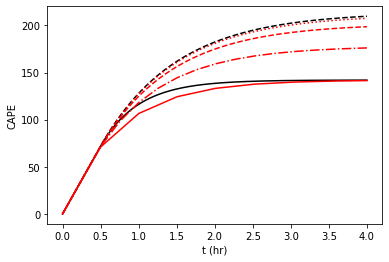

In [10]:
# Predefined case
forcing, t_plot = predefined_settings(0)

plot_old_without_tau_adj(forcing, tau_old, a_crit, a0, deltats, styles, t_plot)

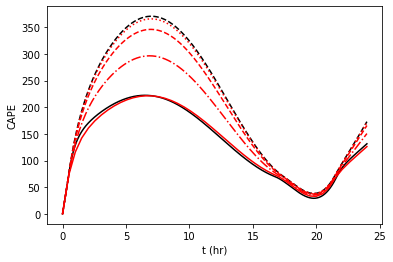

In [11]:
# Predefined case
forcing, t_plot = predefined_settings(1)

plot_old_without_tau_adj(forcing, tau_old, a_crit, a0, deltats, styles, t_plot)

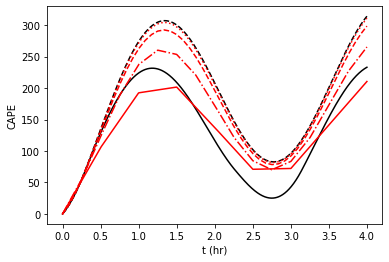

In [12]:
# Predefined case
forcing, t_plot = predefined_settings(2)

plot_old_without_tau_adj(forcing, tau_old, a_crit, a0, deltats, styles, t_plot)

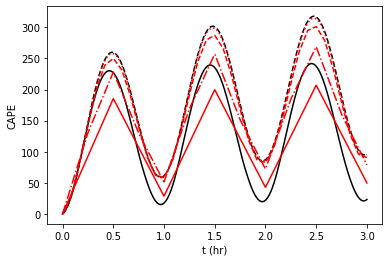

In [13]:
# Predefined case
forcing, t_plot = predefined_settings(3)

plot_old_without_tau_adj(forcing, tau_old, a_crit, a0, deltats, styles, t_plot)

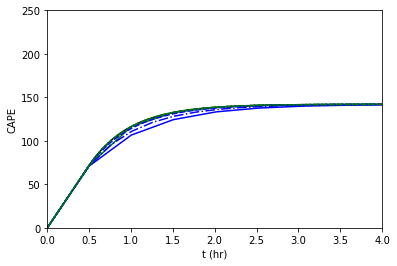

In [14]:
# Predefined case
forcing, t_plot = predefined_settings(0)

old_err, old_adj_err, zmtc_err = plot_methods_vary_timesteps(forcing, tau, a_crit, a0, deltats, styles, t_plot)

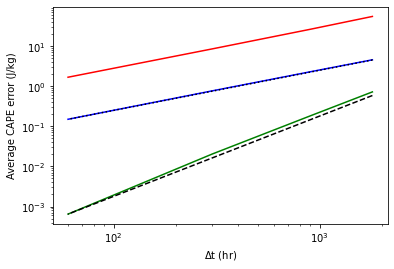

In [15]:
plot_convergence(deltats, old_err, old_adj_err, zmtc_err)

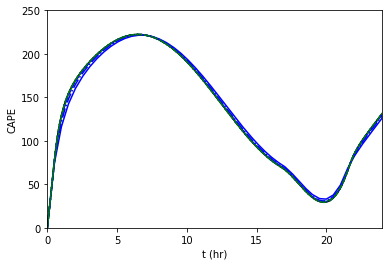

In [16]:
# Predefined case
forcing, t_plot = predefined_settings(1)

old_err, old_adj_err, zmtc_err = plot_methods_vary_timesteps(forcing, tau, a_crit, a0, deltats, styles, t_plot)

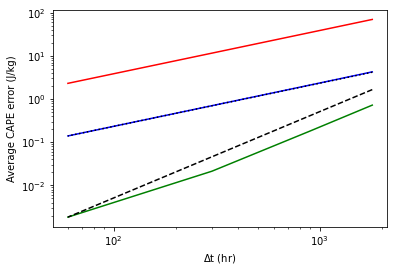

In [17]:
plot_convergence(deltats, old_err, old_adj_err, zmtc_err)

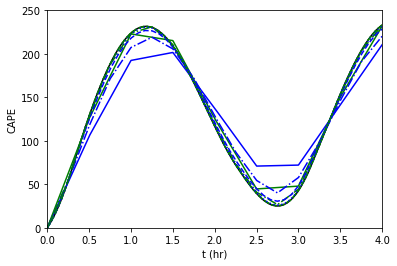

In [18]:
# Predefined case
forcing, t_plot = predefined_settings(2)

old_err, old_adj_err, zmtc_err = plot_methods_vary_timesteps(forcing, tau, a_crit, a0, deltats, styles, t_plot)

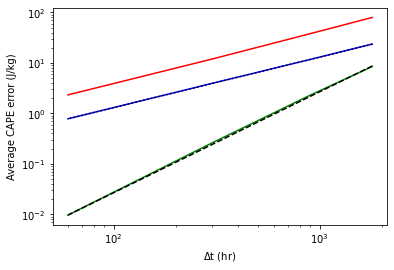

In [19]:
plot_convergence(deltats, old_err, old_adj_err, zmtc_err)

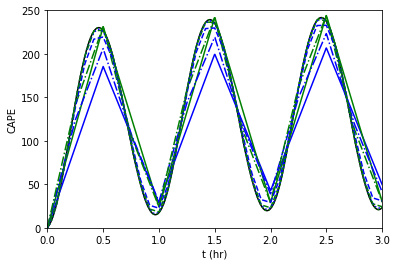

In [20]:
# Predefined case
forcing, t_plot = predefined_settings(3)

old_err, old_adj_err, zmtc_err = plot_methods_vary_timesteps(forcing, tau, a_crit, a0, deltats, styles, t_plot)

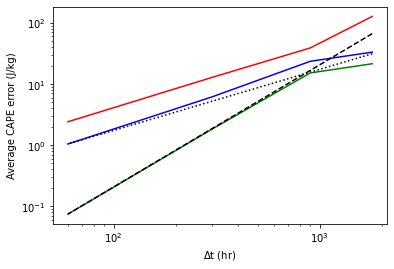

In [21]:
plot_convergence(deltats, old_err, old_adj_err, zmtc_err)